In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import os
import random
import shutil
from pathlib import Path
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

%matplotlib inline


In [2]:
wikiart_dataset_path = "/kaggle/input/wikiart-all-artpieces/wikiart/wikiart"

count = 0
image_mode_not_rbg_count = 0 

for _, _, filesnames in os.walk(wikiart_dataset_path):
  print("---")
  # print(filesnames)
  for files in range(len(filesnames)):
    files = filesnames[files]
    # print(f"Images: {files}")
    try:
      size = os.path.getsize(os.path.join(wikiart_dataset_path, files))
      # print(f"size: {size}")
      if size == 0:
        print(files)
        
      image = Image.open(os.path.join(wikiart_dataset_path, files))
      image_mode = image.mode

      # print(f"Image Mode: {image_mode}")
        
      if image_mode != "RGB":
          image_mode_not_rbg_count = image_mode_not_rbg_count + 1
          image = image.convert("RGB")
          image.save(os.path.join(wikiart_dataset_path, files))

    except OSError as e:
        count = count + 1
#         print(f"Image file: {files} is truncated, exception raised: {e}")

print(f"\nImages converted to RGB: {image_mode_not_rbg_count}")
print(f"Corrupted Images Count: {count}")

---


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Images converted to RGB: 2374
Corrupted Images Count: 2374


### **Creating Dataframe**

In [3]:
wikiart_df = pd.read_csv("/kaggle/input/wikiart-all-artpieces/wikiart_art_pieces.csv")
wikiart_df.head(5)

,artist,style,genre,movement,tags,url,img,file_name
0,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Byzantinearchitecture', 'Arch'...",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,0-ravenna-cappella-arcivescovile-166.jpg
1,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Byzantinearchitecture', 'Arch']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,1-ravenna-cappella-arcivescovile-167.jpg
2,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Prophet', 'History']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,2-ravenna-cappella-arcivescovile-168.jpg
3,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Prophet']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,3-ravenna-cappella-arcivescovile-169.jpg
4,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Prophet']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,4-ravenna-cappella-arcivescovile-171.jpg


In [6]:
print(f"Shape of wikiart dataframe: {wikiart_df.shape}")

Shape of wikiart dataframe: (176436, 8)


In [7]:
wikiart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176436 entries, 0 to 176435
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   artist     176436 non-null  object
 1   style      176436 non-null  object
 2   genre      176436 non-null  object
 3   movement   176436 non-null  object
 4   tags       127710 non-null  object
 5   url        176436 non-null  object
 6   img        176436 non-null  object
 7   file_name  176436 non-null  object
dtypes: object(8)
memory usage: 10.8+ MB


In [8]:
# Checking null values
wikiart_df.isnull().sum()

artist           0
style            0
genre            0
movement         0
tags         48726
url              0
img              0
file_name        0
dtype: int64

In [9]:
print(f'Uniques Value of Movement column: {len(wikiart_df["movement"].unique())}')
print(f'Uniques Value of Artist column: {len(wikiart_df["artist"].unique())}')
print(f'Uniques Value of Style column: {len(wikiart_df["style"].unique())}')
print(f'Uniques Value of Genre column: {len(wikiart_df["genre"].unique())}')

Uniques Value of Movement column: 124
Uniques Value of Artist column: 3209
Uniques Value of Style column: 193
Uniques Value of Genre column: 646


**Counting of images by style column**

In [4]:
image_file_count_by_style = wikiart_df.groupby("style")["file_name"].count()

In [5]:
df = image_file_count_by_style.to_frame()

In [6]:
df.head()

,file_name
style,
Abstract Art,1729
Abstract Expressionism,3909
Academicism,2474
Action painting,105
American Realism,72


In [7]:
import plotly.io as pio

# Ensure file_name is numeric for size argument
df["file_count"] = df["file_name"].astype(float)  

fig = px.scatter(df, x=df.index, y="file_name", 
                 template="plotly_dark", size="file_count", color=df.index, 
                 title="Image count by movement")

pio.show(fig)  # Explicitly show the plot


**From the above plot we can see that:**
* There are images > 5000 for 8 style
* There are many images < 1000 for many style
* So, even with data augmentation of images < 1000 will not effect on training data and accuracy for style < 1000 images will be low

In [8]:
df = df[(df["file_name"] > 2000) & (df["file_name"] < 5000)]

In [16]:
style_list = df.index.to_list()
print(f"Selected Style Lists: {style_list}")

Selected Style Lists: ['Abstract Expressionism', 'Academicism', 'Cubism', 'Minimalism', 'Neoclassicism', 'Northern Renaissance', 'Pop Art', 'Rococo']


**Creating new DataFrame and random sampling the dataframe**

In [9]:
new_wikiart_df = wikiart_df.loc[wikiart_df["style"].isin(df.index)]
new_wikiart_df = new_wikiart_df.sample(frac=1, random_state=7)
new_wikiart_df.head()

,artist,style,genre,movement,tags,url,img,file_name
162042,Tadanori Yokoo,Pop Art,poster,Pop Art,NaN,https://www.wikiart.org/en/tadanori-yokoo/b-1-...,https://uploads6.wikiart.org/images/tadanori-y...,227672-b-1-b-2-1964.jpg
124819,Joan Mitchell,Abstract Expressionism,abstract,Abstract Art,NaN,https://www.wikiart.org/en/joan-mitchell/untit...,https://uploads7.wikiart.org/images/joan-mitch...,163065-untitled-1957.jpg
7860,Albrecht Durer,Northern Renaissance,religious painting,Northern Renaissance,"['Christianity', 'saints-and-apostles', 'Jesus...",https://www.wikiart.org/en/albrecht-durer/st-c...,https://uploads5.wikiart.org/images/albrecht-d...,8814-st-christopher-carrying-the-infant-christ...
89864,Paul Cezanne,Cubism,landscape,Post-Impressionism,"['Tree', 'Leaf']",https://www.wikiart.org/en/paul-cezanne/mont-s...,https://uploads0.wikiart.org/images/paul-cezan...,113152-mont-sainte-victoire-seen-from-les-lauv...
147404,Ed Clark,Abstract Expressionism,abstract,Abstract Expressionism,NaN,https://www.wikiart.org/en/ed-clark/paris-goth...,https://uploads2.wikiart.org/00331/images/ed-c...,203267-paris-gothic-1993-70-5x66-5in-1920x1799...


In [10]:
new_wikiart_df.shape

(24493, 8)

In [11]:
current_directory = "/kaggle/working"
print(f"Current Directory: {current_directory}")

# Define dataset folder
new_folder = "Dataset"
final_directory = os.path.join(current_directory, new_folder)

# Create dataset directory
os.makedirs(final_directory, exist_ok=True)
print(f"Dataset Directory Created: {final_directory}")

# Define subdirectories
subfolders = ["Train", "Test", "Val"]
for folder in subfolders:
    folder_path = os.path.join(final_directory, folder)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Directory Created: {folder_path}")

Current Directory: /kaggle/working
Dataset Directory Created: /kaggle/working/Dataset
Directory Created: /kaggle/working/Dataset/Train
Directory Created: /kaggle/working/Dataset/Test
Directory Created: /kaggle/working/Dataset/Val


In [20]:
style_list = new_wikiart_df["style"].unique().tolist()
print(f"Count of unique Style: {len(style_list)}")

Count of unique Style: 8


In [12]:
current_directory = "/kaggle/working"
dataset_folder = os.path.join(current_directory, "Dataset")

# Create dataset structure
train_folder = os.path.join(dataset_folder, "Train")
val_folder = os.path.join(dataset_folder, "Val")
test_folder = os.path.join(dataset_folder, "Test")

for folder in [train_folder, val_folder, test_folder]:
    os.makedirs(folder, exist_ok=True)

# Define train/val/test split ratios
train_ratio = 0.7
val_ratio = 0.15

# Path to WikiArt dataset 
wikiart_images_path = "/kaggle/input/wikiart-all-artpieces/wikiart/wikiart"
image_files = set(os.listdir(wikiart_images_path)) 

# Iterate over all unique styles
style_list = new_wikiart_df["style"].unique().tolist()

for style in style_list:
    print(f"Processing Style: {style}")

    # Get all images of this style
    images = new_wikiart_df[new_wikiart_df["style"] == style]["file_name"].tolist()
    total_images = len(images)
    
    print(f"Total Images: {total_images}")

    # Split into train, validation, and test
    train_count = round(total_images * train_ratio)
    val_count = round(total_images * val_ratio)
    test_count = total_images - (train_count + val_count)

    print(f"Train: {train_count}, Validation: {val_count}, Test: {test_count}")

    # Create style-specific directories
    train_style_dir = os.path.join(train_folder, style)
    val_style_dir = os.path.join(val_folder, style)
    test_style_dir = os.path.join(test_folder, style)

    for folder in [train_style_dir, val_style_dir, test_style_dir]:
        os.makedirs(folder, exist_ok=True)

    # Function to copy images safely
    def copy_images(image_list, source_folder, destination_folder):
        copied = 0
        for img in image_list:
            if img in image_files:
                src_path = os.path.join(source_folder, img)
                dest_path = os.path.join(destination_folder, img)
                shutil.copy(src_path, dest_path)
                copied += 1
        return copied

    # Copy images to respective folders
    train_copied = copy_images(images[:train_count], wikiart_images_path, train_style_dir)
    val_copied = copy_images(images[train_count:train_count + val_count], wikiart_images_path, val_style_dir)
    test_copied = copy_images(images[train_count + val_count:], wikiart_images_path, test_style_dir)

    print(f"Copied {train_copied} to Train, {val_copied} to Validation, {test_copied} to Test\n")

Processing Style: Pop Art
Total Images: 2517
Train: 1762, Validation: 378, Test: 377
Copied 1762 to Train, 378 to Validation, 377 to Test

Processing Style: Abstract Expressionism
Total Images: 3909
Train: 2736, Validation: 586, Test: 587
Copied 2736 to Train, 586 to Validation, 587 to Test

Processing Style: Northern Renaissance
Total Images: 3089
Train: 2162, Validation: 463, Test: 464
Copied 2162 to Train, 463 to Validation, 464 to Test

Processing Style: Cubism
Total Images: 2530
Train: 1771, Validation: 380, Test: 379
Copied 1771 to Train, 380 to Validation, 379 to Test

Processing Style: Rococo
Total Images: 3537
Train: 2476, Validation: 531, Test: 530
Copied 2476 to Train, 531 to Validation, 530 to Test

Processing Style: Academicism
Total Images: 2474
Train: 1732, Validation: 371, Test: 371
Copied 1732 to Train, 371 to Validation, 371 to Test

Processing Style: Neoclassicism
Total Images: 4360
Train: 3052, Validation: 654, Test: 654
Copied 3052 to Train, 654 to Validation, 654 

In [25]:
train_directory = os.path.join("/kaggle/working/Dataset", "Train")

folders_list = [folder for folder in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, folder))]

print(f"Folders Count: {len(folders_list)}")

Folders Count: 8


In [26]:
def walk_through_directory(dir_path):
    """
    Prints the number of folders and images in the given directory.
    """
    for path, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} folders and {len(filenames)} painting images in {path}.")


In [27]:
walk_through_directory("/kaggle/working/Dataset")

There are 3 folders and 0 painting images in /kaggle/working/Dataset.
There are 8 folders and 0 painting images in /kaggle/working/Dataset/Test.
There are 0 folders and 587 painting images in /kaggle/working/Dataset/Test/Abstract Expressionism.
There are 0 folders and 654 painting images in /kaggle/working/Dataset/Test/Neoclassicism.
There are 0 folders and 377 painting images in /kaggle/working/Dataset/Test/Pop Art.
There are 0 folders and 379 painting images in /kaggle/working/Dataset/Test/Cubism.
There are 0 folders and 371 painting images in /kaggle/working/Dataset/Test/Academicism.
There are 0 folders and 530 painting images in /kaggle/working/Dataset/Test/Rococo.
There are 0 folders and 311 painting images in /kaggle/working/Dataset/Test/Minimalism.
There are 0 folders and 464 painting images in /kaggle/working/Dataset/Test/Northern Renaissance.
There are 8 folders and 0 painting images in /kaggle/working/Dataset/Val.
There are 0 folders and 586 painting images in /kaggle/working

### **Visualizing the images**

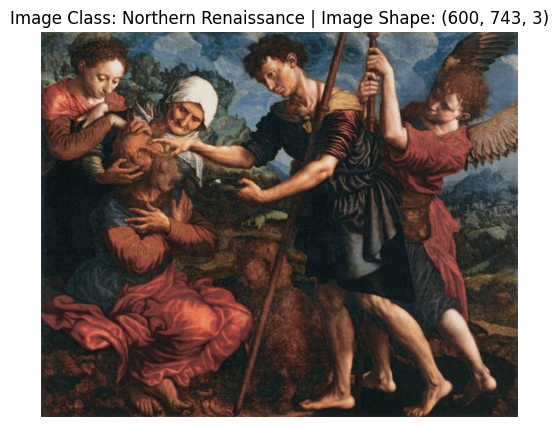

In [28]:
dataset_directory = Path("/kaggle/working/Dataset")

# Get all image paths (searching inside Train, Test, and Val)
image_path_list = list(dataset_directory.glob("*/*/*.jpg"))

# Ensure there are images available
if image_path_list:
    # Select a random image
    image_path = random.choice(image_path_list)

    # Get the class (folder name) of the image
    image_class = image_path.parent.stem  # Extracts folder name

    # Open image
    img = Image.open(image_path)
    img_array = np.asarray(img)

    # Display image
    plt.figure(figsize=(12, 5))
    plt.imshow(img_array)
    plt.title(f"Image Class: {image_class} | Image Shape: {img_array.shape}")
    plt.axis(False)
    plt.show()
else:
    print("No images found in the dataset directory.")

## **Model Training**

In [13]:
dataset_directory = Path("/kaggle/working/Dataset")
train_directory = dataset_directory / "Train"
val_directory = dataset_directory / "Val"
test_directory = dataset_directory / "Test"

# Image size for ResNet
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  

# Load datasets using TensorFlow
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"  # Classes are inferred from folder structure
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)


Found 17145 files belonging to 8 classes.
Found 3675 files belonging to 8 classes.
Found 3673 files belonging to 8 classes.


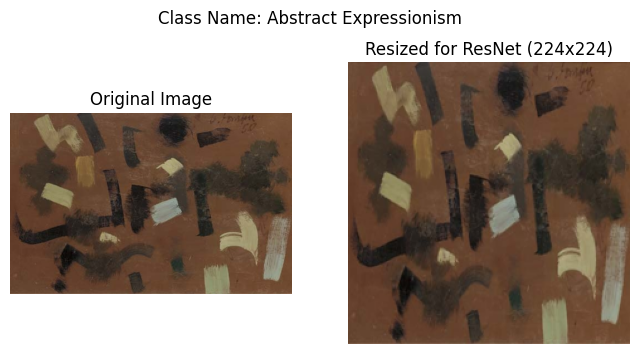

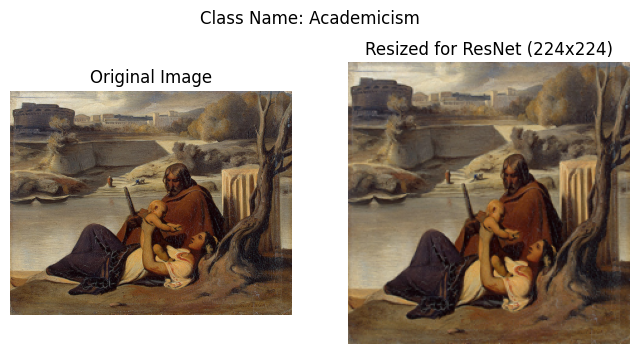

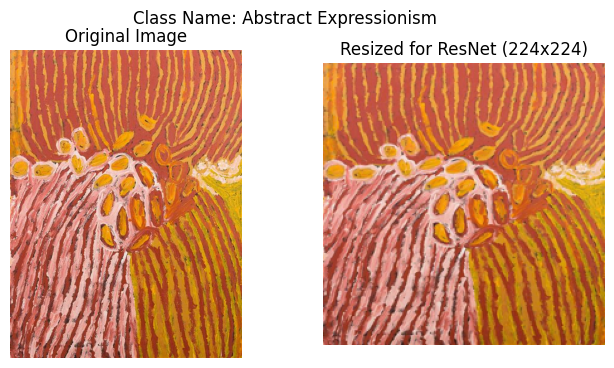

In [14]:
# Function to plot transformed images
def plot_images(image_path_list, n=3, seed=None):
    """ Select random images, apply resizing transformation, and plot original vs transformed images """
    
    if seed:
        random.seed(seed)

    image_samples = random.sample(image_path_list, k=n)

    for img_path in image_samples:
        with Image.open(img_path) as img:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            
            # Original Image
            ax[0].imshow(img)
            ax[0].set_title("Original Image")
            ax[0].axis(False)

            # Resized Image (Simulating TensorFlow Resizing)
            img_resized = img.resize(IMG_SIZE)
            ax[1].imshow(img_resized)
            ax[1].set_title("Resized for ResNet (224x224)")
            ax[1].axis(False)

            fig.suptitle(f"Class Name: {img_path.parent.stem}", fontsize=12)

# Get all image paths
image_path_list = list(dataset_directory.glob("*/*/*.jpg"))

# Plot images
plot_images(image_path_list, n=3, seed=42)


In [15]:
class_names = train_data.class_names
print(f"List of Class Names: {class_names}")


List of Class Names: ['Abstract Expressionism', 'Academicism', 'Cubism', 'Minimalism', 'Neoclassicism', 'Northern Renaissance', 'Pop Art', 'Rococo']


### **Training on ResNet-50 by unfreezing the parameters**  

In [16]:
from tensorflow.keras.applications import ResNet50
# Load pre-trained ResNet50 model without the top layer
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3)
)

# Freeze all layers (initially)
base_model.trainable = False

# Add new classification head
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(class_names), activation="softmax")  # Multi-class classification
])

# Compile model (initial training with frozen layers)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
history_frozen = model.fit(
    train_data, validation_data=val_data, epochs=5 
)


Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.5119 - loss: 1.3344 - val_accuracy: 0.6610 - val_loss: 0.9071
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.6581 - loss: 0.8891 - val_accuracy: 0.6833 - val_loss: 0.8370
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.6976 - loss: 0.7927 - val_accuracy: 0.7097 - val_loss: 0.7914
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - accuracy: 0.7175 - loss: 0.7383 - val_accuracy: 0.7105 - val_loss: 0.7601
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.7343 - loss: 0.6875 - val_accuracy: 0.7053 - val_loss: 0.7766


In [19]:
# Unfreeze the last 50% of layers
for layer in base_model.layers[-75:]:  
    layer.trainable = True  # Allow training

# Recompile model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary after unfreezing layers
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 19,979,528 (76.22 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [21]:
# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Reduce learning rate if validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
)

# Model checkpoint: Save best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_resnet_finetuned.keras", monitor="val_loss", save_best_only=True
)

callbacks = [early_stopping, reduce_lr, checkpoint]


In [23]:
history_finetune = model.fit(
    train_data, validation_data=val_data, epochs=50, callbacks=callbacks
)

Epoch 1/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 97s 129ms/step - accuracy: 0.7056 - loss: 0.7935 - val_accuracy: 0.7529 - val_loss: 0.6748 - learning_rate: 1.0000e-04
Epoch 2/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.8338 - loss: 0.4436 - val_accuracy: 0.7657 - val_loss: 0.6872 - learning_rate: 1.0000e-04
Epoch 3/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.8904 - loss: 0.3003 - val_accuracy: 0.7488 - val_loss: 0.8574 - learning_rate: 1.0000e-04
Epoch 4/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.9252 - loss: 0.2133 - val_accuracy: 0.7535 - val_loss: 1.1131 - learning_rate: 1.0000e-04
Epoch 5/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.9615 - loss: 0.1178 - val_accuracy: 0.7880 - val_loss: 0.8793 - learning_rate: 5.0000e-05
Epoch 6/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.9882 - loss: 0.0440 - val_accuracy: 0.7986 - val_loss: 0.9423 - learning_rate: 5.0000e-05
Epoch 7/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/st

In [26]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7564 - loss: 0.6742
Test Accuracy: 0.7593


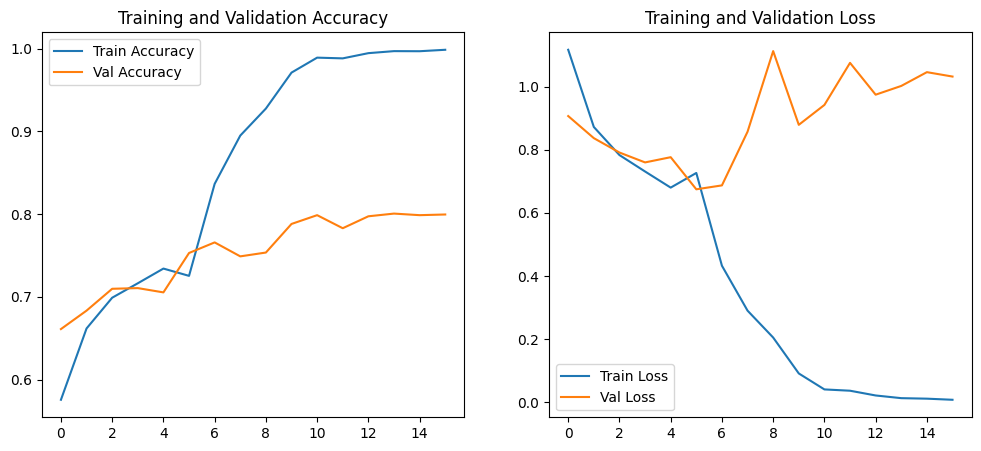

In [27]:
# Combine both training phases
acc = history_frozen.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history_frozen.history["val_accuracy"] + history_finetune.history["val_accuracy"]
loss = history_frozen.history["loss"] + history_finetune.history["loss"]
val_loss = history_frozen.history["val_loss"] + history_finetune.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()


In [28]:
predictions = model.predict(test_data)

# Convert to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = np.concatenate([y for _, y in test_data], axis=0)

115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step


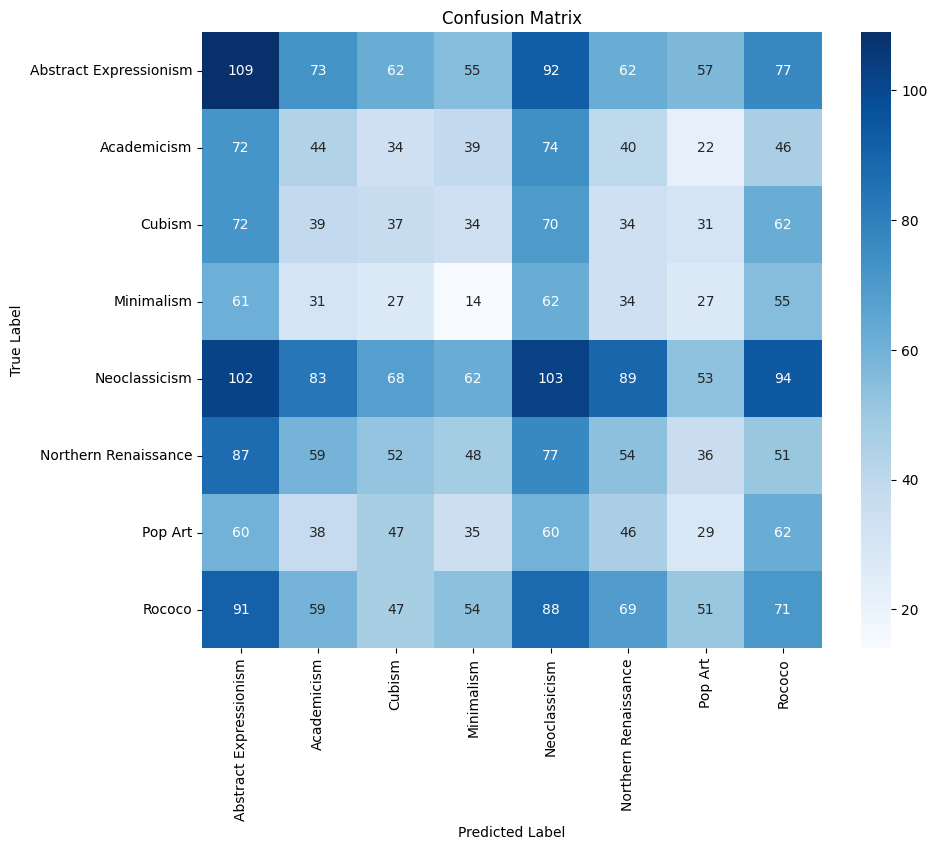

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get class names from the dataset
class_names = list(test_data.class_names)  # Ensure test_data has class names

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### **Training on  EfficientNetB0  by unfreezing the parameters**  

In [32]:
# Load EfficientNetB0 with pre-trained weights
base_model = tf.keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top=False, 
    input_shape=(224, 224, 3)
)

# Freeze the base model initially
base_model.trainable = False

# Add new classification head
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(class_names), activation="softmax")  # Multi-class classification
])

# Compile model (initial training with frozen layers)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,563 (16.71 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [33]:
history = model.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 61s 79ms/step - accuracy: 0.5650 - loss: 1.1394 - val_accuracy: 0.7007 - val_loss: 0.7872
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.7104 - loss: 0.7649 - val_accuracy: 0.7235 - val_loss: 0.7214
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.7545 - loss: 0.6454 - val_accuracy: 0.7263 - val_loss: 0.7124
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.7733 - loss: 0.5966 - val_accuracy: 0.7371 - val_loss: 0.7034
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.7998 - loss: 0.5313 - val_accuracy: 0.7420 - val_loss: 0.7011


In [34]:
# Unfreeze the last 50% of layers
for layer in base_model.layers[:-25]:  
    layer.trainable = True  # Allow training

# Recompile model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary after unfreezing layers
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,563 (16.71 MB)

 Trainable params: 2,874,788 (10.97 MB)

 Non-trainable params: 1,504,775 (5.74 MB)

In [35]:
# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Reduce learning rate if validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
)

# Model checkpoint: Save best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "efficientnet_finetuned.keras", monitor="val_loss", save_best_only=True
)

callbacks = [early_stopping, reduce_lr, checkpoint]


In [36]:
history_finetune = model.fit(
    train_data, validation_data=val_data, epochs=50, callbacks=callbacks
)

Epoch 1/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 173s 207ms/step - accuracy: 0.7126 - loss: 0.7966 - val_accuracy: 0.7671 - val_loss: 0.6302 - learning_rate: 1.0000e-04
Epoch 2/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 68s 126ms/step - accuracy: 0.8301 - loss: 0.4580 - val_accuracy: 0.7755 - val_loss: 0.6140 - learning_rate: 1.0000e-04
Epoch 3/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 68s 126ms/step - accuracy: 0.8629 - loss: 0.3601 - val_accuracy: 0.7886 - val_loss: 0.5966 - learning_rate: 1.0000e-04
Epoch 4/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 67s 124ms/step - accuracy: 0.8907 - loss: 0.2951 - val_accuracy: 0.7948 - val_loss: 0.6051 - learning_rate: 1.0000e-04
Epoch 5/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 66s 124ms/step - accuracy: 0.9176 - loss: 0.2341 - val_accuracy: 0.7959 - val_loss: 0.6117 - learning_rate: 1.0000e-04
Epoch 6/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 67s 124ms/step - accuracy: 0.9322 - loss: 0.1962 - val_accuracy: 0.7962 - val_loss: 0.6418 - learning_rate: 1.0000e-04
Epoch 7/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 67s 1

In [37]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7881 - loss: 0.5860
Test Accuracy: 0.7925


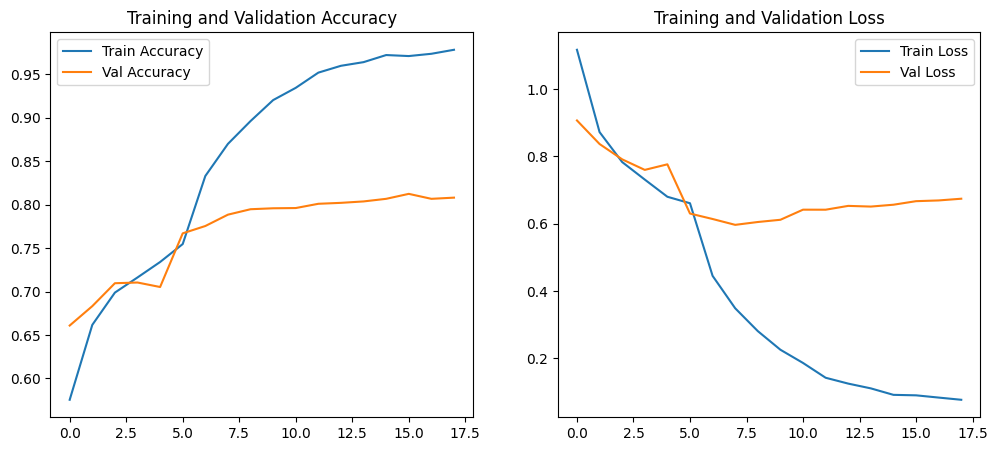

In [38]:
# Combine both training phases
acc = history_frozen.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history_frozen.history["val_accuracy"] + history_finetune.history["val_accuracy"]
loss = history_frozen.history["loss"] + history_finetune.history["loss"]
val_loss = history_frozen.history["val_loss"] + history_finetune.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()


In [39]:
predictions = model.predict(test_data)

# Convert to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = np.concatenate([y for _, y in test_data], axis=0)

115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step


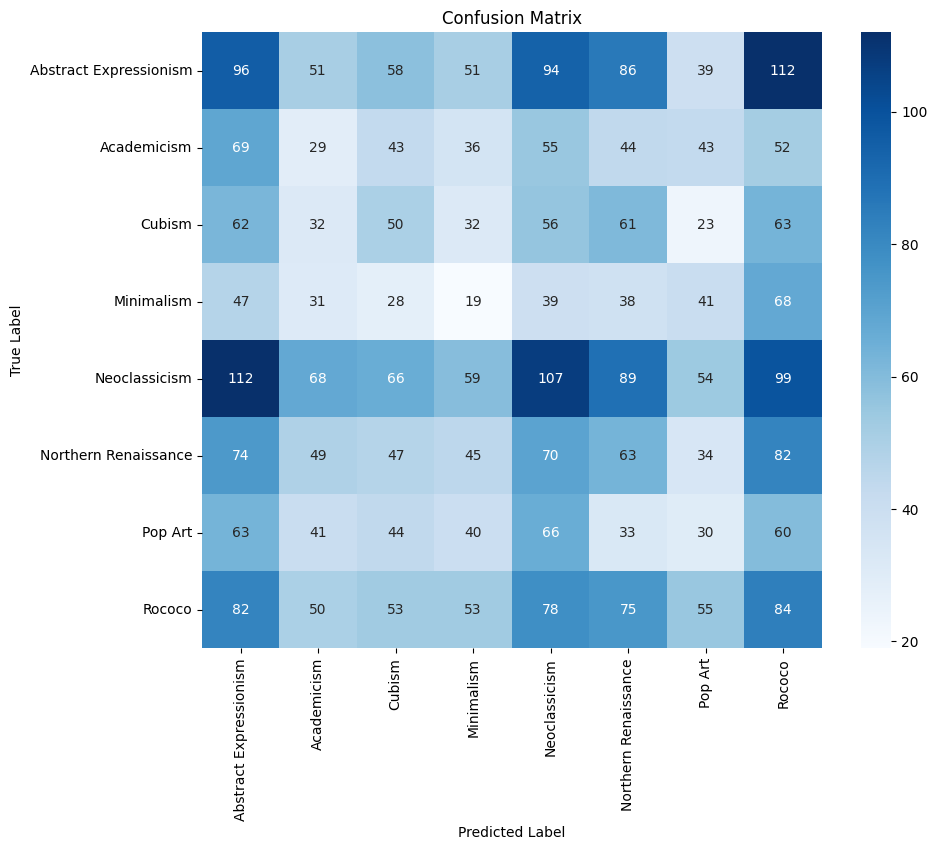

In [40]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get class names from the dataset
class_names = list(test_data.class_names)  # Ensure test_data has class names

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()